In [ ]:
!pip install -q datasets
!pip install -U datasets huggingface_hub fsspec transformers optuna

#Creating the dataset
- Load the **adibvafa/CodonTransformer** dataset from Hugging Face.
- Identify the top 5 organisms in the dataset based on the number of rows.
- Randomly sample 20,000 rows for each of these organisms to create a balanced dataset.
- Split the resulting dataset into training and validation sets.
- Repeat the above process using the test split from Hugging Face to create a balanced test set.

In [2]:
from datasets import load_dataset, Dataset,concatenate_datasets
from collections import Counter
import random

In [3]:
dataset = load_dataset("adibvafa/CodonTransformer")
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['dna', 'protein', 'organism', 'GeneID', 'description', 'tokenized', 'fine_tuned', 'len'],
        num_rows: 1001197
    })
})


In [4]:
dataset["train"][0]

{'dna': 'ATGGATTACCGACCTTCTGATAGTAGTGGTACAGATGATGACCTGCCTCCATCTCATCAAGGTAGATATCAAAGAAACGCCAGACCTACCGGGAATGGAAGGCCTTCAGTTCTCAATTCTGCTCCTTTATCACGGGTGCACAATGAAATGGAAACTCAAATTCATCTCATTGAGCAAGAAGCTTATAGCTCGATACTCCGCGCATTTAAAGCCCAGTCCGATGCTATTACCTGGGAGAAAGAAAGTTTGATCACTGAACTCAGAAAAGAACTTCGAGTGTCTGATGAGGAACACAGAGAGCTGTTATCAAGGGTTAACGCTGATGAAATGATCAGGCGAATAAGGGAATGGAGAAAGGCAAACAGCCTTCAGTCTAGTGTTCCTCAGCTGGTTCATGATGCTCCGAGTCCGGCTGTATCAGGATCACGTAAGAAGCAAAAGACATCACAATCAATCGCCTCATTAGCGATGGGCCCACCATCTCCTTCTTTGCACCCTTCAATGCAACCATCGTCATCTGCACTAAGAAGGGGAGGTCCTCCACCAGGTCCAAAGACCAAGAAGCCAAAGACATCGATGCAGTACCCATCTACAGGCATTGCTGGAAGGCCCCAGGCTGGCGCTTTAACAAATGAACCAGGTGAATCGGGATCATATGACCCGTTGGTTGGAAGGAAGGTATGGACGAAGTGGCCTGATGACAACCAATACTACGAAGCTGTTATAACTGACTACAACCCTGTTGAGGGGCGTCATGCTTTAGTGTATGATATTAACTCTGCGAATGAAACCTGGGAATGGGTAAATCTTAAAGAGATATCTCCGGGAGATATCAGATGGGAAGGTGAAGATCCTGGGATTTCTCGTAAAGGAGGACATCCTGGGCAAGGCCGTGGAACAAAAACCATGGCTCGTGGTGGTCCTGCAAGCAATGCGGGTGGTAGAGGTAGGGGAAGCATGAGGATGCAGCAACCTAAGACACAGAATGGCA

In [5]:
unique_organisms = set(example["organism"] for example in dataset["train"])
print(unique_organisms)
organism_counts = Counter(dataset["train"]["organism"])
print(organism_counts)

{'Lonsdalea populi', 'Citrobacter youngae', 'Enterobacter roggenkampii', 'Pantoea allii', 'Pectobacterium aroidearum', 'Proteus faecis', 'Dickeya dadantii 3937', 'Drosophila melanogaster', 'Edwardsiella piscicida', 'Nicotiana tabacum chloroplast', 'Serratia nevei', 'Enterobacter mori', 'Shigella boydii', 'Yersinia alsatica', 'Escherichia ruysiae', 'Pluralibacter gergoviae', 'Enterobacter asburiae', 'Yersinia intermedia', 'Arabidopsis thaliana', 'Enterobacter sichuanensis', 'Edwardsiella anguillarum ET080813', 'Raoultella terrigena', 'Serratia rubidaea', 'Yersinia mollaretii ATCC 43969', 'Enterobacter hormaechei', 'Yersinia ruckeri', 'Pseudomonas putida', 'Yersinia rochesterensis', 'Homo sapiens', 'Serratia plymuthica AS9', 'Escherichia fergusonii', 'Thermococcus litoralis', 'Salmonella enterica subsp. enterica serovar Typhimurium str. LT2', 'Pyrococcus yayanosii', 'Klebsiella aerogenes', 'Cronobacter turicensis', 'Yersinia proxima', 'Escherichia coli general', 'Thermoccoccus kodakarens

In [6]:
# get top 5 organisms
train_split = dataset["train"]
organism_counts = Counter(train_split["organism"])


top_5_organisms = [org for org, _ in organism_counts.most_common(5)]
print("Top 5 organisms:")
for org in top_5_organisms:
    print(f"{org} ({organism_counts[org]})")

#  Filter the rows with the top 5 organisms
filtered_dataset = train_split.filter(lambda ex: ex["organism"] in top_5_organisms)
print(f"\nFiltered dataset size: {len(filtered_dataset)}")


Top 5 organisms:
Homo sapiens (111997)
Nicotiana tabacum (69642)
Mus musculus (68447)
Danio rerio (47006)
Arabidopsis thaliana (40558)


Filter:   0%|          | 0/1001197 [00:00<?, ? examples/s]


Filtered dataset size: 337650


In [7]:
#Considering 20,000 rows from each organism ramdomly
samples_per_org = 20000
subset_datasets = []
used_sequences_by_org = {}


for organism in top_5_organisms:
    # Filter dataset for this organism
    org_dataset = filtered_dataset.filter(lambda ex: ex["organism"] == organism)

    # Randomly sample 20,000 rows
    indices = random.sample(range(len(org_dataset)), samples_per_org)
    sampled_dataset = org_dataset.select(indices)
    used_sequences_by_org[organism] = set(sampled_dataset["dna"])

    subset_datasets.append(sampled_dataset)


Filter:   0%|          | 0/337650 [00:00<?, ? examples/s]

Filter:   0%|          | 0/337650 [00:00<?, ? examples/s]

Filter:   0%|          | 0/337650 [00:00<?, ? examples/s]

Filter:   0%|          | 0/337650 [00:00<?, ? examples/s]

Filter:   0%|          | 0/337650 [00:00<?, ? examples/s]

In [8]:
final_dataset = concatenate_datasets(subset_datasets)
print(f"\nFinal balanced dataset size: {len(final_dataset)}")  # (20,000*5=100000)


Final balanced dataset size: 100000


In [9]:
# Split the final dataset into train and validation (80/20 split)
split_dataset = final_dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)

# Access the splits
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

# Print the sizes
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Train set size: 80000
Validation set size: 20000


In [13]:
test_sample_sizes = {
    'Homo sapiens': random.randint(5000, 10000),
    'Nicotiana tabacum': random.randint(5000, 10000),
    'Mus musculus': random.randint(5000, 10000),
    'Danio rerio': random.randint(2000, 5000),
    'Arabidopsis thaliana': random.randint(2000, 5000),
}

test_samples = []

# Build test set with no overlap
for organism in top_5_organisms:
    org_dataset = filtered_dataset.filter(lambda ex: ex["organism"] == organism)
    available = [ex for ex in org_dataset if ex["dna"] not in used_sequences_by_org[organism]]
    sample_count = min(len(available), test_sample_sizes[organism])
    sampled = random.sample(available, sample_count)
    test_samples.extend(sampled)

# Convert to Hugging Face dataset
test_dataset = Dataset.from_list(test_samples)

In [14]:
# Collect DNA sequences from train and val sets
train_dna = set(train_dataset["dna"])
val_dna = set(val_dataset["dna"])
test_dna = set(test_dataset["dna"])

# Check if test set is unique from train ansd val sets
overlap_with_train = test_dna.intersection(train_dna)
overlap_with_val = test_dna.intersection(val_dna)

if not overlap_with_train and not overlap_with_val:
    print("Test set created with NO overlap with train/val sets.")
else:
    print("Overlap detected!")
    print(f"Overlap with train: {len(overlap_with_train)}")
    print(f"Overlap with val: {len(overlap_with_val)}")

print(f"Test set size: {len(test_dataset)}")

Test set created with NO overlap with train/val sets.
Test set size: 30941


In [15]:
train_dataset[0]

{'dna': 'ATGATTTTCCAAAAAGAAACCATGGAGGTTGAAATCTTGTCAACAAAGTTGATAAAACCATCTTCACCAACTCCAAATTACCTTCAAAATTACAAACTATCTTTCTTTGATCAAATAGCTGATGAGGCACATTTACCTCTTGTTCTTTTCTATCCTCCTGGCAATAGCAATACCAAGAATAATATTGCAGCTGAAGAACAGCTCGAGCAATCCTTATCTAGAATTTTAACCCATGTTTACCCAATTGCTGGCAGATTTACTGAGGATAACTCCTCGATTCACTGCCTCGATCAAGGGGTTAAATTTGTCAAAGCCAAGGTAAATTGTAAGCTCAATGACTTTCTTGAGAAAGCACACAAAGATGTCAATCTTGCCTTATCTTGTTGGCCTAAAGATACTTGGTATGTGGATGAAACTAATTTACTCATTGTGCCAATTGTCATTGTACAAGTCACAAAATTCAATTGCGGTGGCATGGCTCTATCTATGAGCCATGCACATACCGCGATGGATGGTTTCACAACTTTTACATTCGTTCACGAGTGGTCAAAAGTGTGCAAATTGGGGATTCCTACAGAGAAAATCAACTTTTTGAGCTTTAATTTGGCTAAGATTTTCCCACCAAGAGATGCATCGAAAATTCTCTTGCCTCGTATCCCCCAGGAAAATCGTATGGATGCTAAACTAGTTGCCAAGAAGTTATACATCAACCAAGATTCTATTTCAAGACTCAGAGAAGAATTAACAAAATCAACGGATTCTGGAGCTTTATGCTTTAAGCCCTCAAGAGTTGAAATGATTATAGCGCTCTTATGGAGGGCTTTAATCCGCGCTTCAGAGAAACAACACGGGCATTTGAGACGTTCTATAATGGGCATTCCAATAAACTTGCGTACTAAGCTGATTTCTTTACCCCAAGTAGAAAAATCTTTTGGAAATCTTGTAATCGATGCTCCGGTAAAATTTGTACCCGAGGAGATCCCCAACATGG

# Extend tokenizer with custom tokens
- We use the **lhallee/CodonBERT** model form huggingface as our base model.
- We extend it's tokenizer by adding new codons, amino acid tokens and the organism name tokens.
- We tokenize the train, test, val dataset.
- We split a part of the training data and validation data to use it for hyperparamter tuning with Optuna.

In [ ]:
amino_acids = ['Q', 'I', 'L', 'F', 'N', '_', 'G', 'T', 'H', 'P', 'M', 'D', 'E', 'A', 'C', 'W', 'Y', 'S', 'K', 'R', 'V']
amino_acids_special = ["_" + aa for aa in amino_acids]
amino_acids_special

['_Q',
 '_I',
 '_L',
 '_F',
 '_N',
 '__',
 '_G',
 '_T',
 '_H',
 '_P',
 '_M',
 '_D',
 '_E',
 '_A',
 '_C',
 '_W',
 '_Y',
 '_S',
 '_K',
 '_R',
 '_V']

In [ ]:
organism_tokens = [f"[{organism.upper()}]" for organism in top_5_organisms]
organism_tokens

['[HOMO SAPIENS]',
 '[NICOTIANA TABACUM]',
 '[MUS MUSCULUS]',
 '[DANIO RERIO]',
 '[ARABIDOPSIS THALIANA]']

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("lhallee/CodonBERT", do_basic_tokenize=False)
model = AutoModelForMaskedLM.from_pretrained("lhallee/CodonBERT")

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/356 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/348M [00:00<?, ?B/s]

In [ ]:
dnas = train_dataset["dna"]
unique_codons = set()

for dna in dnas:
      codons = [dna[i:i+3] for i in range(0, len(dna), 3)]
      unique_codons.update(codons)

print(f"Unique codons in dataset: {len(unique_codons)}")

64


In [ ]:
new_codons = list(unique_codons - set(tokenizer.get_vocab().keys()))
print(f"Codons to be added: {len(new_codons)}")

37


In [ ]:
vocab = amino_acids_special + organism_tokens + new
print(f"Created {len(vocab)} new tokens.")
num_added_tokens = tokenizer.add_tokens(vocab)
print(f'Added {num_added_tokens} new tokens.')
model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Created 63 tokens.
Added 63 new tokens.


Embedding(132, 768, padding_idx=0)

In [ ]:
tokens = list(tokenizer.get_vocab().keys())
tokens.sort()
print(f"Total tokens {len(tokens)}")
print(tokens)

['AAA',
 'AAC',
 'AAG',
 'AAT',
 'AAU',
 'ACA',
 'ACC',
 'ACG',
 'ACT',
 'ACU',
 'AGA',
 'AGC',
 'AGG',
 'AGT',
 'AGU',
 'ATA',
 'ATC',
 'ATG',
 'ATT',
 'AUA',
 'AUC',
 'AUG',
 'AUU',
 'CAA',
 'CAC',
 'CAG',
 'CAT',
 'CAU',
 'CCA',
 'CCC',
 'CCG',
 'CCT',
 'CCU',
 'CGA',
 'CGC',
 'CGG',
 'CGT',
 'CGU',
 'CTA',
 'CTC',
 'CTG',
 'CTT',
 'CUA',
 'CUC',
 'CUG',
 'CUU',
 'GAA',
 'GAC',
 'GAG',
 'GAT',
 'GAU',
 'GCA',
 'GCC',
 'GCG',
 'GCT',
 'GCU',
 'GGA',
 'GGC',
 'GGG',
 'GGT',
 'GGU',
 'GTA',
 'GTC',
 'GTG',
 'GTT',
 'GUA',
 'GUC',
 'GUG',
 'GUU',
 'TAA',
 'TAC',
 'TAG',
 'TAT',
 'TCA',
 'TCC',
 'TCG',
 'TCT',
 'TGA',
 'TGC',
 'TGG',
 'TGT',
 'TTA',
 'TTC',
 'TTG',
 'TTT',
 'UAA',
 'UAC',
 'UAG',
 'UAU',
 'UCA',
 'UCC',
 'UCG',
 'UCU',
 'UGA',
 'UGC',
 'UGG',
 'UGU',
 'UUA',
 'UUC',
 'UUG',
 'UUU',
 '[ARABIDOPSIS THALIANA]',
 '[CLS]',
 '[DANIO RERIO]',
 '[HOMO SAPIENS]',
 '[MASK]',
 '[MUS MUSCULUS]',
 '[NICOTIANA TABACUM]',
 '[PAD]',
 '[SEP]',
 '[UNK]',
 '_A',
 '_C',
 '_D',
 '_E',
 '_F',

In [ ]:
# Test a dummy sample
print(len(tokenizer))
tokenizer.tokenize("ATG AAG _M_L_P__")

132


['ATG', 'AAG', '_M', '_L', '_P', '__']

In [ ]:
def tokenize_function(example):
    dna_seq = example["dna"]
    protein_seq = example["protein"]
    organism = example["organism"].upper()  # Assuming organism is provided clearly

    # DNA sequence explicitly segmented into codons
    codon_seq = " ".join([dna_seq[i:i+3] for i in range(0, len(dna_seq), 3)])
    formatted_protein = "_".join(list(protein_seq))

    # Organism token clearly marked
    organism_token = f"[{organism}]"

    # Combined clearly as organism context + DNA codons + protein sequence
    combined_seq = f"{organism_token} {codon_seq} {tokenizer.sep_token} {formatted_protein}"

    return tokenizer(
        combined_seq,
        padding="max_length",
        truncation=True,
        max_length=512,
    )

In [ ]:
train_dataset[0]

{'dna': 'ATGTCAGCCTGCAGTAAGATCCGCCACATTGTGAGGCTCCGCCAAATGCTACAACGGTGGAGGAAGAAGGCCGCTTCGGCTGCTCGTCGCCGCGTCCCGACCGATGTACCTTCGGGACATGTAGCAGTTACAGTTGGTAGCAGTTGCAAGAGATTTGTAGTCCGTACCACTTACTTGAACCACCCAGTGTTCAAGAAACTGTTGTCACAGGCAGAGGAAGAGTTTGGTTTTGCTAACTCTGGCCTTTTAGCCATTCCTTGTGATGAATCTTTGTTTGAAGAGTTGCTTTGTTACTTGGCTCGATTCGACTCCGCTAACAATAATCTGTCACGGTTCATGAACTTTGAAGATTTCCAGAGATATTGTCACATGGATATCCGAAGCAACCTTGATTTTTGGGGTGATTCCAGACCCCTTTTGCATTAA',
 'protein': 'MSACSKIRHIVRLRQMLQRWRKKAASAARRRVPTDVPSGHVAVTVGSSCKRFVVRTTYLNHPVFKKLLSQAEEEFGFANSGLLAIPCDESLFEELLCYLARFDSANNNLSRFMNFEDFQRYCHMDIRSNLDFWGDSRPLLH_',
 'organism': 'Nicotiana tabacum',
 'GeneID': 107824822.0,
 'description': 'XM_016651628.1:19-444 LOC107824822 ',
 'tokenized': 'M_ATG S_TCA A_GCC C_TGC S_AGT K_AAG I_ATC R_CGC H_CAC I_ATT V_GTG R_AGG L_CTC R_CGC Q_CAA M_ATG L_CTA Q_CAA R_CGG W_TGG R_AGG K_AAG K_AAG A_GCC A_GCT S_TCG A_GCT A_GCT R_CGT R_CGC R_CGC V_GTC P_CCG T_ACC D_GAT V_GTA P_CCT S_TCG G_GGA H_CAT V_GTA A_GCA V_GTT T_ACA V_GTT G_GGT 

In [ ]:
ids = tokenize_function(train_dataset[0])['input_ids']
tokenizer.decode(ids)

'[CLS] [NICOTIANA TABACUM] ATG TCA GCC TGC AGT AAG ATC CGC CAC ATT GTG AGG CTC CGC CAA ATG CTA CAA CGG TGG AGG AAG AAG GCC GCT TCG GCT GCT CGT CGC CGC GTC CCG ACC GAT GTA CCT TCG GGA CAT GTA GCA GTT ACA GTT GGT AGC AGT TGC AAG AGA TTT GTA GTC CGT ACC ACT TAC TTG AAC CAC CCA GTG TTC AAG AAA CTG TTG TCA CAG GCA GAG GAA GAG TTT GGT TTT GCT AAC TCT GGC CTT TTA GCC ATT CCT TGT GAT GAA TCT TTG TTT GAA GAG TTG CTT TGT TAC TTG GCT CGA TTC GAC TCC GCT AAC AAT AAT CTG TCA CGG TTC ATG AAC TTT GAA GAT TTC CAG AGA TAT TGT CAC ATG GAT ATC CGA AGC AAC CTT GAT TTT TGG GGT GAT TCC AGA CCC CTT TTG CAT TAA [SEP] [UNK] _S _A _C _S _K _I _R _H _I _V _R _L _R _Q _M _L _Q _R _W _R _K _K _A _A _S _A _A _R _R _R _V _P _T _D _V _P _S _G _H _V _A _V _T _V _G _S _S _C _K _R _F _V _V _R _T _T _Y _L _N _H _P _V _F _K _K _L _L _S _Q _A _E _E _E _F _G _F _A _N _S _G _L _L _A _I _P _C _D _E _S _L _F _E _E _L _L _C _Y _L _A _R _F _D _S _A _N _N _N _L _S _R _F _M _N _F _E _D _F _Q _R _Y _C _H _M _D _I _R _S _N _L _D _F 

In [ ]:
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=False)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=False)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=False)

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/22645 [00:00<?, ? examples/s]

In [ ]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split

df = tokenized_train_dataset.to_pandas()

train_df, val_df = train_test_split(
    df,
    train_size=2000,
    test_size=500,
    stratify=df["organism"],
    random_state=42
)

# Creating smaller dataset for hyperparameter tuning
tuning_train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
tuning_val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

In [ ]:
columns_to_remove = ['dna',
 'protein',
 'organism',
 'GeneID',
 'description',
 'tokenized',
 'fine_tuned',
 'len'
 ]
tokenized_train_dataset = tokenized_train_dataset.remove_columns(columns_to_remove)
tokenized_val_dataset = tokenized_val_dataset.remove_columns(columns_to_remove)
tokenized_test_dataset = tokenized_test_dataset.remove_columns(columns_to_remove)

In [ ]:
tuning_train_dataset = tuning_train_dataset.remove_columns(columns_to_remove)
tuning_val_dataset = tuning_val_dataset.remove_columns(columns_to_remove)

# Training the Model
- We initialize the DataCollator, Trainer for training the model.
- We perform hyperparameter tuning by using Optuna.
- We plot the training and validation loss curve.

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
trainable_params

86537604

In [ ]:
tuning_train_dataset, tuning_val_dataset

(Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 2000
 }),
 Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 500
 }))

In [ ]:
from transformers import AutoModelForMaskedLM, Trainer, TrainingArguments

def model_init():
    model = AutoModelForMaskedLM.from_pretrained("lhallee/CodonBERT")
    model.resize_token_embeddings(len(tokenizer))
    return model

def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-7, 5e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32, 64]),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
    }

training_args = TrainingArguments(
    output_dir="./codonbert-mlm",
    learning_rate=5e-5,
    num_train_epochs=4,
    per_device_train_batch_size=64,
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_strategy="epoch",
    bf16=True,
    dataloader_num_workers=4,
    report_to="none",
    load_best_model_at_end=True
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tuning_train_dataset,
    eval_dataset=tuning_val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

best_run = trainer.hyperparameter_search(
    direction="minimize",
    hp_space=hp_space,
    n_trials=7,
    backend="optuna"
)

print("Best trial:")
print(best_run)

<ipython-input-36-e3f891ade40f>:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[I 2025-06-04 21:39:27,720] A new study created in memory with name: no-name-56c8821b-9b33-4e6d-a587-7a9a7d653c3b


Epoch,Training Loss,Validation Loss
1,4.421500,4.258007
2,4.140100,3.981755
3,3.970800,3.892230
4,3.910200,3.863761


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].
[I 2025-06-04 21:40:10,797] Trial 0 finished with value: 3.8637609481811523 and parameters: {'learning_rate': 1.8143352471582475e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.2016386455291935}. Best is trial 0 with value: 3.8637609481811523.


Epoch,Training Loss,Validation Loss
1,3.980000,3.686169
2,3.652100,3.618887
3,3.610400,3.590124
4,3.587000,3.580375


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].
[I 2025-06-04 21:40:53,814] Trial 1 finished with value: 3.5803754329681396 and parameters: {'learning_rate': 0.000241009430165244, 'per_device_train_batch_size': 32, 'weight_decay': 0.19277921136507462}. Best is trial 1 with value: 3.5803754329681396.


Epoch,Training Loss,Validation Loss
1,4.592900,4.508097
2,4.478400,4.457376
3,4.453400,4.453549
4,4.451400,4.452878


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].
[I 2025-06-04 21:41:37,053] Trial 2 finished with value: 4.452877998352051 and parameters: {'learning_rate': 2.109257780930251e-06, 'per_device_train_batch_size': 32, 'weight_decay': 0.26617499935553507}. Best is trial 1 with value: 3.5803754329681396.


Epoch,Training Loss,Validation Loss
1,4.775100,4.734236
2,4.677800,4.660231
3,4.647700,4.640748
4,4.628900,4.641373


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].
[I 2025-06-04 21:42:24,748] Trial 3 finished with value: 4.6413726806640625 and parameters: {'learning_rate': 1.435581566725158e-07, 'per_device_train_batch_size': 16, 'weight_decay': 0.25295549844158355}. Best is trial 1 with value: 3.5803754329681396.


Epoch,Training Loss,Validation Loss
1,4.427900,4.269625
2,4.163300,4.022317
3,4.011900,3.926920
4,3.944900,3.900210


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].
[I 2025-06-04 21:43:13,741] Trial 4 finished with value: 3.900209665298462 and parameters: {'learning_rate': 8.592024209770986e-06, 'per_device_train_batch_size': 16, 'weight_decay': 0.19967518415096328}. Best is trial 1 with value: 3.5803754329681396.


Epoch,Training Loss,Validation Loss
1,4.667800,4.577251


[I 2025-06-04 21:43:24,628] Trial 5 pruned. 


Epoch,Training Loss,Validation Loss
1,4.560800,4.483629
2,4.452300,4.434104


[I 2025-06-04 21:43:46,942] Trial 6 pruned. 


Best trial:
BestRun(run_id='1', objective=3.5803754329681396, hyperparameters={'learning_rate': 0.000241009430165244, 'per_device_train_batch_size': 32, 'weight_decay': 0.19277921136507462}, run_summary=None)


In [ ]:
best_run.hyperparameters

{'learning_rate': 0.000241009430165244,
 'per_device_train_batch_size': 32,
 'weight_decay': 0.19277921136507462}

In [ ]:
from transformers import AutoModelForMaskedLM, Trainer, TrainingArguments


training_args = TrainingArguments(
    output_dir="./codonbert-mlm",
    learning_rate=best_run.hyperparameters["learning_rate"],
    weight_decay=best_run.hyperparameters["weight_decay"],
    num_train_epochs=25,
    per_device_train_batch_size=best_run.hyperparameters["per_device_train_batch_size"],
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_strategy="epoch",
    bf16=True,
    dataloader_num_workers=4,
    report_to="none",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

<ipython-input-40-adfe304f2839>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,3.638700,3.374675
2,3.086800,2.927051
3,2.820900,2.665457
4,2.505100,2.268883
5,2.304700,2.256989
6,2.282000,2.243113
7,2.265100,2.230099
8,2.248700,2.219820
9,2.232300,2.206508
10,2.216800,2.196362


KeyboardInterrupt: 

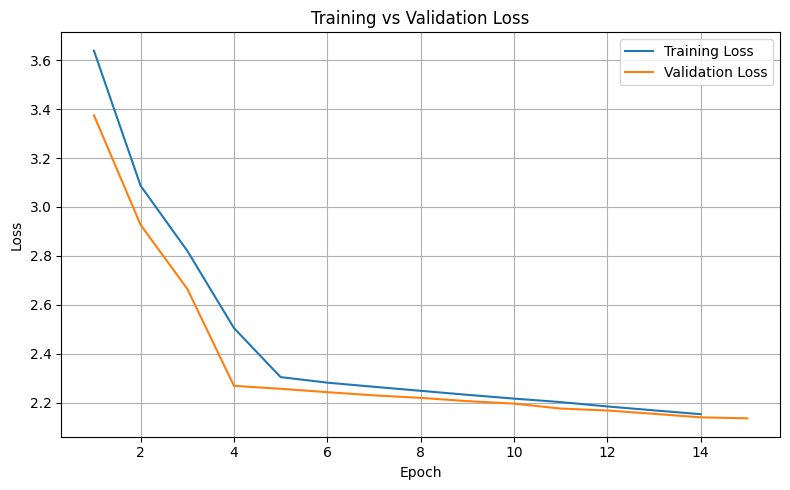

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values from log history
logs = trainer.state.log_history
train_loss = [log["loss"] for log in logs if "loss" in log]
val_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]

train_epochs = list(range(1, len(train_loss) + 1))
val_epochs = list(range(1, len(val_loss) + 1))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_epochs, train_loss, label="Training Loss")
plt.plot(val_epochs, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
trainer.save_model("./codonbert-mlm-finetuned")
tokenizer.save_pretrained("./codonbert-mlm-finetuned")

('./codonbert-mlm-finetuned/tokenizer_config.json',
 './codonbert-mlm-finetuned/special_tokens_map.json',
 './codonbert-mlm-finetuned/vocab.txt',
 './codonbert-mlm-finetuned/added_tokens.json',
 './codonbert-mlm-finetuned/tokenizer.json')

In [ ]:
  !zip -r codon-model-corrected-1.zip ./codonbert-mlm-finetuned
  from google.colab import files
  files.download('codon-model-corrected-1.zip')

In [ ]:
  !rm -rf codonbert-mlm-finetuned
  !unzip codon-model-corrected-1.zip -d .

# Calculate Perpelxity
- We load the saved model and evaluate it's perplexity.

In [ ]:
saved_model = AutoModelForMaskedLM.from_pretrained("./codonbert-mlm-finetuned")
saved_tokenizer = AutoTokenizer.from_pretrained("./codonbert-mlm-finetuned")

test_args = TrainingArguments(
    output_dir="./codonbert-mlm-test",
    per_device_eval_batch_size=32,
    dataloader_num_workers=4,
    report_to="none"
)

test_trainer = Trainer(
    model=saved_model,
    args=test_args,
    eval_dataset=tokenized_val_dataset,
    tokenizer=saved_tokenizer,
    data_collator=data_collator,
)

metrics = test_trainer.evaluate()
print("Test set evaluation metrics:")
print(metrics)

import math
perplexity = math.exp(metrics["eval_loss"])
print(f"Perplexity: {perplexity:.2f}")

<ipython-input-52-6611a212f0ea>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  test_trainer = Trainer(


Test set evaluation metrics:
{'eval_loss': 2.141181707382202, 'eval_model_preparation_time': 0.0032, 'eval_runtime': 20.1847, 'eval_samples_per_second': 990.848, 'eval_steps_per_second': 30.964}
Perplexity: 8.51
